In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import utils
from PIL import Image
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import f1_score
from keras.utils.vis_utils import plot_model
from keras import backend as K
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os, sys

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/classifier/dataset'
%cd /content/drive/MyDrive/classifier/dataset/

Mounted at /content/drive
/content/drive/MyDrive/classifier/dataset


In [2]:
def f1_macro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(np.isnan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_temp(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def resize_image(src_img, size, bg_color): 
    src_img.thumbnail(size, Image.ANTIALIAS) 
    new_image = Image.new("RGB", size, bg_color)
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
    return new_image

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

def augment(image, label, n):
    generated_images = []
    samples = np.expand_dims(image, 0)

    datagen = ImageDataGenerator(horizontal_flip=True,
                                 width_shift_range=0.15,
                                 height_shift_range=0.15,
                                 rotation_range=30,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[0.9, 1.2],
                                 channel_shift_range=15)
  
    iterator = datagen.flow(samples, batch_size=1)

    for i in range(n):
        batch = iterator.next()
        generated_images.append(batch[0].astype('uint8'))

    return generated_images, [label]*n

In [3]:
X, y = [], []
size = (128,128)
background_color="white"
test_image_files = os.listdir(folder_path) 

for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(folder_path, test_image_files[file_idx])).convert('RGB')
    resized_img = np.array(resize_image(img, size, background_color)) 
    cropped_img = np.array(crop_max_square(img).resize((size[0], size[1]), Image.LANCZOS)) 
    X.append(cropped_img) 
    y.append(test_image_files[file_idx][0]) 

X = np.asarray(X)
y = np.reshape(np.asarray(y), (len(y), 1))
y = y.astype('float64') - np.ones((len(y), 1))
y = y.astype('<U1')
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (40, 128, 128, 3) 
y shape: (40, 1)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

print('X_train shape:', X_train.shape, '\ny_train shape:', y_train.shape, 
      '\nX_test shape:', X_test.shape, '\ny_test shape:', y_test.shape)

X_train shape: (32, 128, 128, 3) 
y_train shape: (32, 1) 
X_test shape: (8, 128, 128, 3) 
y_test shape: (8, 1)


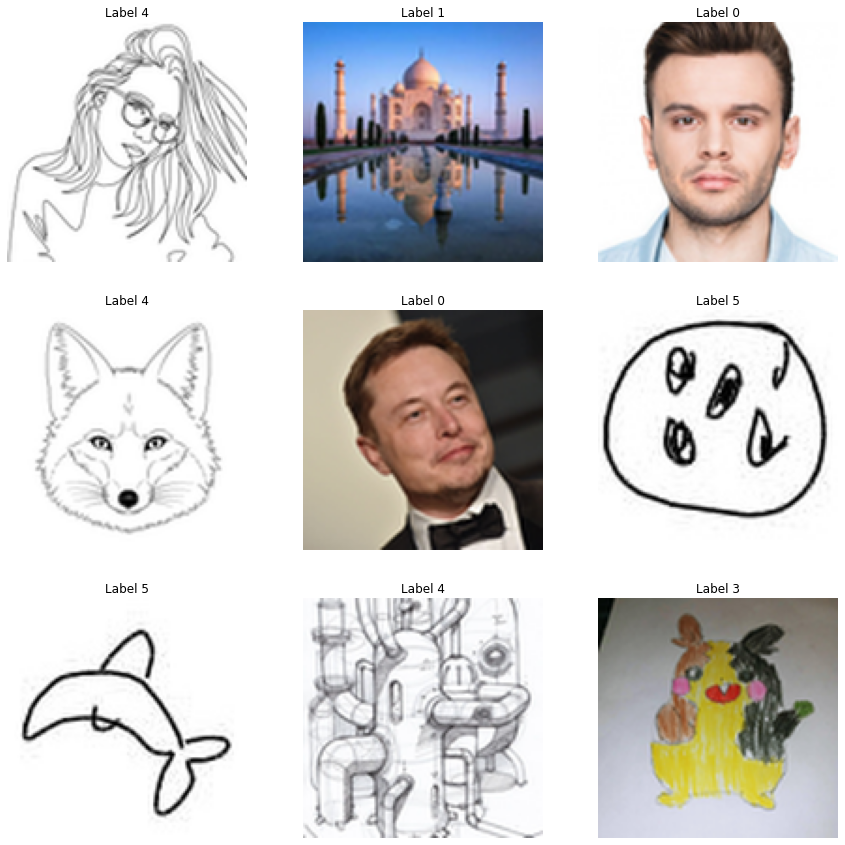

In [5]:
ax = []
fig = plt.figure(figsize=(15,15))

for i in range(9):
    ax.append(fig.add_subplot(3, 3, i+1)) 
    plt.imshow(X_train[i])
    plt.title(str('Label ' + y_train[i][0]))
    plt.axis('off')

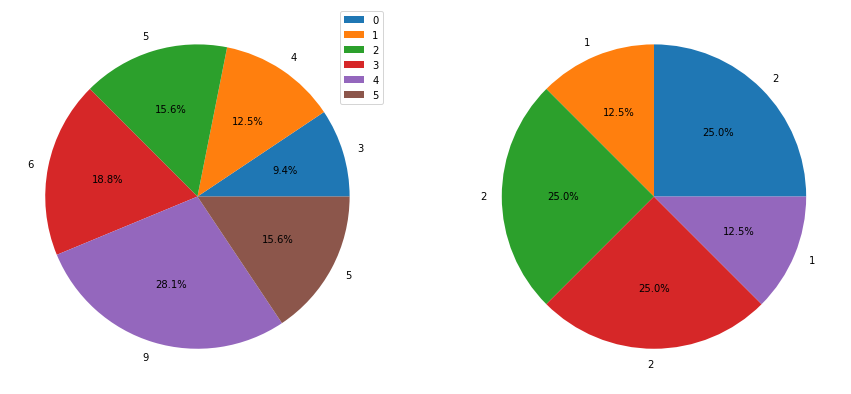

In [6]:
train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121)
ax1.pie(train_counts[1], labels=train_counts[1], autopct='%1.1f%%')
ax2 = fig.add_subplot(122)
ax2.pie(test_counts[1], labels=test_counts[1], autopct='%1.1f%%')
ax1.legend(train_counts[0])
plt.show()

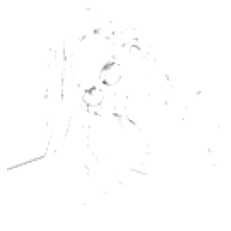

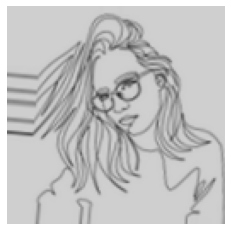

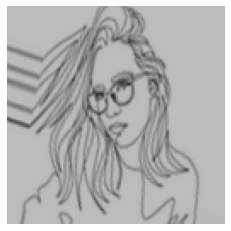

In [7]:
generated_images, generated_labels = augment(X_train[0], y_train[0], 10)

for i in range(3):
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.show()

In [8]:
augmented_images, augmented_labels = [], []

for i in range(len(X_train)):
    generated_images, generated_labels = augment(X_train[i], y_train[i], 10)
    augmented_images.extend(generated_images)
    augmented_labels.extend(generated_labels)

X_train, y_train = utils.shuffle(np.array(augmented_images), np.array(augmented_labels))

print('X_train shape:', X_train.shape, '\ny_train shape:', y_train.shape)

X_train shape: (320, 128, 128, 3) 
y_train shape: (320, 1)


In [9]:
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = y_train.astype('float32').reshape((-1,1))
y_test = y_test.astype('float32').reshape((-1,1))

In [10]:
# TensorFlow

'''
loss = 'sparse_categorical_crossentropy'
optimizer = 'Adam'
#metrics = ['accuracy', f1_macro]
metrics = ['accuracy']
epochs = 10
batch_size = 32

class ImageClassifier:
    def __init__(self):
        self.model = Sequential()

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        hist = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
        return hist

    def evaluate(self, X_test, y_test):
        #loss, acc, f1_macro = self.model.evaluate(X_test, y_test)
        #return loss, acc, f1_macro
        loss, acc = self.model.evaluate(X_test, y_test)
        return loss, acc

    def build_model(self):
        self.model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(128, 128, 3)))
        self.model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
        self.model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
        self.model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.add(Dense(units=512, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(units=6, activation='softmax'))

        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

classifier = ImageClassifier()
classifier.build_model()
plot_model(classifier.model, to_file="../architecture.jpg")

hist = classifier.train(X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size) # X_val, y_val
#loss, acc, f1_macro = classifier.evaluate(X_test, y_test)
loss, acc = classifier.evaluate(X_test, y_test)

acc = hist.history['accuracy'][0]
print("Accuracy:", round(acc, 3), "\n")

'''


# PyTorch

loss = nn.CrossEntropyLoss()
criterion = loss
epochs = 1
batch_size = 32

class ImageClassifier(nn.Module):
    def __init__(self): 
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.dropout2 = nn.Dropout(0.25)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 6)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout4(x)
        x = nn.functional.softmax(self.fc2(x), dim=1)
        return x

    def train(self, trainloader, valloader, epochs, optimizer, criterion):
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels.flatten())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

    def evaluate(self, dataloader, criterion):
        correct = 0
        total = 0
        loss = 0.0
        with torch.no_grad():
            for data in dataloader:
                images, labels = data
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss += criterion(outputs, labels.flatten()).item()
        accuracy = 100.0 * correct / total
        loss = loss / len(dataloader)
        return loss

classifier = ImageClassifier()
optimizer = optim.Adam(classifier.parameters())

train_dataset = TensorDataset(torch.from_numpy(X_train.transpose((0, 3, 1, 2))).float(), torch.from_numpy(y_train).long())
test_dataset = TensorDataset(torch.from_numpy(X_test.transpose((0, 3, 1, 2))).float(), torch.from_numpy(y_test).long())

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classifier.train(trainloader, valloader, epochs, optimizer, criterion)

test_loss = classifier.evaluate(valloader, criterion)

KeyboardInterrupt: ignored